# Task 2: Coordinate Transformations

In this notebook we will use what we have learned about marker detection in the last notebook

## Imports

In [1]:
# imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import yaml
import io

## Setup

We again load the camera parameters. This time not only need them for preprocessing our image, but we will also use them when estimating where the markers are relative to the camera.

In [2]:
# load camera parameters
with open("../camera_intrinsics.yml", 'r') as stream:
    camera_intrinsics = yaml.safe_load(stream)
camera_matrix = np.array(camera_intrinsics["camera_matrix"]["data"]).reshape((3,3))
distortion_coefficients = np.array(camera_intrinsics["distortion_coefficients"]["data"])

The other component for estimating the markers' poses and postions we need to know beforehand, is the size of our markers.

In [3]:
# set marker size
marker_size = 0.05

## Detect Aruco Markers

**Task:** Use the *cv2.aruco.DICT_ARUCO_ORIGINAL* dictionary for detecting the markers in the given image. 

**Note:** In this specific case, you don't have to undistort the image after loading it, because the function that handles the marker pose estimation (*solvePnP*, which we will use in the next task) will do that internally. So you just have to detect the markers in the undistorted image, image distortions will be accounted for post detection.

**Note:** The list that contains the marker ids should be named *ids*, in order for the provided code to run without changes.

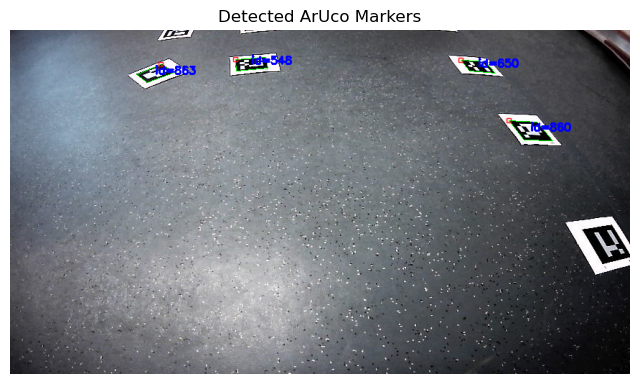

In [4]:
# load image
img = cv2.imread("./2024-09-12_17-29-34/img_282.jpg")

### Your code here ###
# img = cv2.undistort(img, camera_matrix, distortion_coefficients)

# setup detector
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

# detect markers in the image
corners, ids, rejected = detector.detectMarkers(img)

# draw markers onto the image
img_with_markers = cv2.aruco.drawDetectedMarkers(img.copy(), corners, ids)
###

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_with_markers, cv2.COLOR_BGR2RGB))
plt.title("Detected ArUco Markers")
plt.axis('off')
plt.show()

## Pose Estimation

**Task:** Use OpenCV's *solvePnP* function to estimate the poses of the markers detected in the previous task. 

**Note:** The function should get the camera matrix and distortion parameters as arguments, because it internally handles the *undistortion* step that we did separately in the last notebook.

In [5]:
# estimate marker poses using the detected marker corners from the image, the camera parameters, and the (known) size of the marker 
marker_rvecs = []
marker_tvecs = []

# marker corners (defines 3d coordinates of the marker corners in the marker's local coordinate frame; centered at the marker center)
marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, -marker_size / 2, 0],
                          [-marker_size / 2, -marker_size / 2, 0]])

### Your code here ###
# cv2.solvePnP estimates rvec (rotation vector; orientation of the marker relative to the camera) 
# and tvec (translation vector: position of the marker relative to the camera)
if ids is not None:
    for corner in corners: # corner contains the detected 2d image coordinates of those same corners
        # solvePnP expects 2d-3d correspondences
        ret, rvec, tvec = cv2.solvePnP(
            marker_points, # 3d object points
            corner, # 2d image points (from detection)
            camera_matrix, # camera intrinsics
            distortion_coefficients # distortion parameters (no prior undistortion is needed)
        )
        marker_rvecs.append(rvec)
        marker_tvecs.append(tvec)

# debug: results
for i, marker_id in enumerate(ids.flatten()):
    print(f"Marker ID {marker_id}:")
    print(f"Rotation Vector (rvec):\n{marker_rvecs[i]}")
    print(f"Translation Vector (tvec):\n{marker_tvecs[i]}\n")

###

Marker ID 548:
Rotation Vector (rvec):
[[ 2.27722785]
 [-0.20682553]
 [ 0.13990833]]
Translation Vector (tvec):
[[-0.12472726]
 [-0.24125509]
 [ 0.69771621]]

Marker ID 863:
Rotation Vector (rvec):
[[ 2.14627477]
 [ 0.92036903]
 [-0.36121222]]
Translation Vector (tvec):
[[-0.28844868]
 [-0.23245113]
 [ 0.68742175]]

Marker ID 860:
Rotation Vector (rvec):
[[ 2.29259902]
 [-0.11142979]
 [ 0.09852386]]
Translation Vector (tvec):
[[ 0.28044866]
 [-0.11507887]
 [ 0.57405686]]

Marker ID 650:
Rotation Vector (rvec):
[[ 2.29451717]
 [-0.06685786]
 [ 0.04143059]]
Translation Vector (tvec):
[[ 0.26463879]
 [-0.26147827]
 [ 0.74303198]]



**Task:** Use OpenCV's *drawFrameAxes* function to visualise the estimated marker poses.

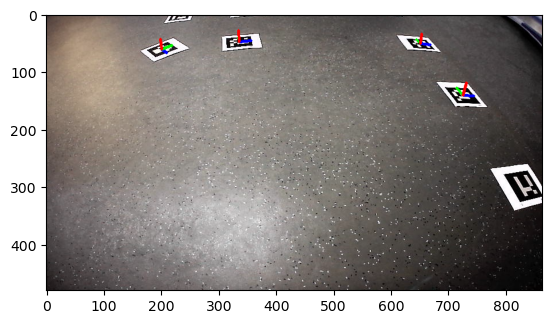

In [6]:
# visualise the estimated marker poses in the image
img_axis = img.copy()
### Your code here ###
if ids is not None:
    for rvec, tvec in zip(marker_rvecs, marker_tvecs):
        # Draw coordinate axes for each marker
        cv2.drawFrameAxes(
            img_axis,                 # image to draw on
            camera_matrix,            # camera intrinsics
            distortion_coefficients,  # distortion parameters
            rvec,                     # rotation vector
            tvec,                     # translation vector
            marker_size / 2           # length of each axis in meters (half marker size looks good)
        )

###

plt.imshow(img_axis)

## Projecting Aruco Marker Positions to Robot and World Frame

In [7]:
def rotation_matrix(x_rotation, y_rotation, z_rotation):
    alpha = z_rotation
    beta = y_rotation
    gamma = x_rotation

    # https://en.wikipedia.org/wiki/Rotation_matrix
    # rotates around z, then y, then x

    return np.array([
        [np.cos(alpha)*np.cos(beta), np.cos(alpha)*np.sin(beta)*np.sin(gamma)-np.sin(alpha)*np.cos(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)+np.sin(alpha)*np.sin(gamma)],
        [np.sin(alpha)*np.cos(beta), np.sin(alpha)*np.sin(beta)*np.sin(gamma)+np.cos(alpha)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma)-np.cos(alpha)*np.sin(gamma)],
        [-np.sin(beta), np.cos(beta)*np.sin(gamma), np.cos(beta)*np.cos(gamma)]
    ])

In [8]:
def vectors_to_transformation_matrix(rotation, translation):
    ### Your code here ###
    R = rotation_matrix(rotation[0], rotation[1], rotation[2])
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation
    #T[3, 3] = 1
    ###
    return T

In [9]:
def transformation_matrix_to_vectors(t):
    # Extract translation
    translation = t[:3, 3]

    # Extract rotation matrix
    R = t[:3, :3]

    # Extract Euler angles (x_rotation, y_rotation, z_rotation)
    # Handle singularities safely
    if abs(R[2, 0]) != 1:
        y_rotation = -np.arcsin(R[2, 0])
        x_rotation = np.arctan2(R[2, 1] / np.cos(y_rotation), R[2, 2] / np.cos(y_rotation))
        z_rotation = np.arctan2(R[1, 0] / np.cos(y_rotation), R[0, 0] / np.cos(y_rotation))
    else:
        # Gimbal lock case
        z_rotation = 0
        if R[2, 0] == -1:
            y_rotation = np.pi / 2
            x_rotation = z_rotation + np.arctan2(R[0, 1], R[0, 2])
        else:
            y_rotation = -np.pi / 2
            x_rotation = -z_rotation + np.arctan2(-R[0, 1], -R[0, 2])

    return np.array([x_rotation, y_rotation, z_rotation]), translation


### Projecting to robot frame

In [10]:
# offset from camera to robot frame
x_offset_camera = 0.03
y_offset_camera = 0
z_offset_camera = 0.28

offset_camera_robot = np.array([x_offset_camera,y_offset_camera,z_offset_camera]) 

In [11]:
# angle from camera to robot frame
x_angle_camera = -140 #degrees
y_angle_camera = 0
z_angle_camera = -90 #degrees

rotation_camera_robot = np.array([np.radians(x_angle_camera), np.radians(y_angle_camera), np.radians(z_angle_camera)])

**Task:** Create transform matrix from camera frame to robot frame.

In [12]:
### Your code here ###
# Define the camera's position (translation) relative to the robot [x, y, z] in meters
camera_translation = np.array([0.0, 0.1, 0.2])  # Example: 10 cm forward, 20 cm up

# Define the camera's rotation relative to the robot [x, y, z] in radians
# Example: camera tilted slightly downward around X-axis
camera_rotation = np.array([np.deg2rad(-15), 0, 0])  # -15° pitch

# Build the transformation matrix using your helper
T_camera_robot = vectors_to_transformation_matrix(camera_rotation, camera_translation)
###

**Task:** Create transform matrices for all markers, project them into the robot coordinate frame, and transform the resulting matrices back into rotation and translation vectors. Also print the id and world position for each marker.

In [13]:
# create transform matrices for all markers, project them into the robot coordinate frame
# transform them to rotation and translation vectors
marker_rvecs_robot = []
marker_tvecs_robot = []
### Your code here ###
if ids is not None:
    for i, marker_id in enumerate(ids.flatten()):
        # Create transformation matrix for this marker (from camera frame)
        R_marker, _ = cv2.Rodrigues(marker_rvecs[i])  # convert rvec -> rotation matrix
        t_marker = marker_tvecs[i].flatten()          # translation vector
        T_marker_camera = np.eye(4)
        T_marker_camera[:3, :3] = R_marker
        T_marker_camera[:3, 3] = t_marker

        # Project into robot frame: T_marker_robot = T_camera_robot @ T_marker_camera
        T_marker_robot = T_camera_robot @ T_marker_camera

        # Convert back to rotation/translation vectors
        rotation_vec, translation_vec = transformation_matrix_to_vectors(T_marker_robot)
        marker_rvecs_robot.append(rotation_vec)
        marker_tvecs_robot.append(translation_vec)

        # Debug: print results
        print(f"Marker ID {marker_id}:")
        print(f"  World position (robot frame): {translation_vec}")
        print(f"  Rotation (radians): {rotation_vec}\n")
###

Marker ID 548:
  World position (robot frame): [-0.12472726  0.04754772  0.93638352]
  Rotation (radians): [ 2.03002186 -0.19068196 -0.05692675]

Marker ID 863:
  World position (robot frame): [-0.28844868  0.05338729  0.9241612 ]
  Rotation (radians): [2.19546093 0.67222297 0.46230534]

Marker ID 860:
  World position (robot frame): [0.28044866 0.1374192  0.78428095]
  Rotation (radians): [ 2.03516761 -0.11663216 -0.01916392]

Marker ID 650:
  World position (robot frame): [0.26463879 0.03974222 0.98538934]
  Rotation (radians): [ 2.03422715 -0.05909365 -0.02034193]



Now, let us visualise the results of our pose estimation. We start with a visualisation of where the detected markers are, realitve to our robot, on the vertical plane. 

Text(0.5, 1.0, 'vertical plane')

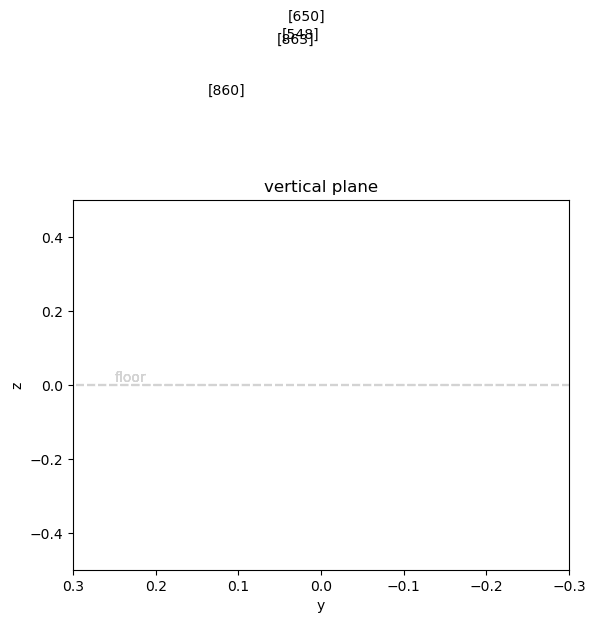

In [14]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z")
    plt.xlabel("y")
    plt.xlim([-0.3, 0.3])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.25, 0.01, "floor", color="lightgray")

plt.gca().invert_xaxis()
plt.title("vertical plane")

We can see that, although all markers in the image are obviously placed directly on the floor, our estimated positions don't line uo perfectly with it. Some markers are estimated to "float" a bit above the floor, some are estimated to be slightly below it. This kind of imperfect measurement is something we must always expect when working with imperfect data. In our example, our camera calibration might not be completely optimal our images might be noisy, etc. Overall, however, these results aren't too bad and definitely still usable for our purposes. 

Next, we visualise where the markers are on the horizontal plane (i.e. the floor), relative to our robot. Because the robot is the reference point, it will always be at position (0,0).

Text(0.5, 1.0, 'horizontal plane')

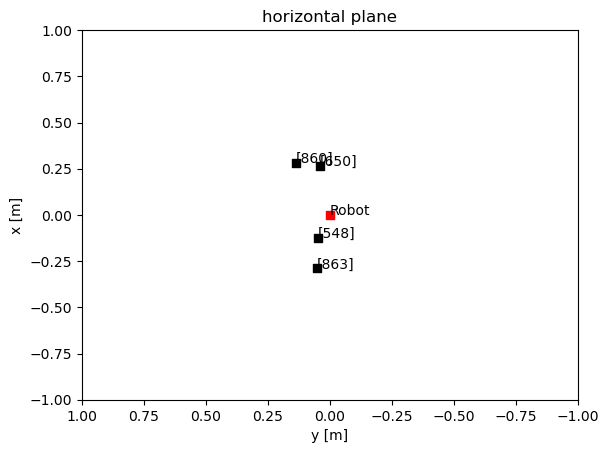

In [15]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter([0], [0], color="red", marker="s")
plt.text(0, 0, "Robot")
plt.gca().invert_xaxis()
plt.title("horizontal plane")

### Projecting to world frame

Now that we know, where the markers are relative to our robot, we want to determine, where they are in our world coordinate frame. We will later need this to, for example, implement the landmark detection and localisation, as well as the SLAM algorithm for our robot.  
Let's assume that our robot started at the origin of the world coordinate frame. Now it has moved 40cm forwards and 25cm to the left, with a current heading o 30° to the right.


In [16]:
# offset from robot to world frame
x_offset_world = 0.4
y_offset_world = 0.25
z_offset_world = 0

# angle from robot to world frame
x_angle_world = 0 #degrees
y_angle_world = 0
z_angle_world = -30

offset_robot_world = np.array([x_offset_world,y_offset_world,z_offset_world]) 
rotation_robot_world = np.array([np.radians(x_angle_world), np.radians(y_angle_world), np.radians(z_angle_world)])

**Task:** Create transform matrix from robot to world frame.

In [20]:
### Your code here ###
# rotation matrix around z-axis
cz = np.cos(rotation_robot_world[2])
sz = np.sin(rotation_robot_world[2])

Rz = np.array([
    [cz, -sz, 0],
    [sz,  cz, 0],
    [0,   0,  1]
])

T_robot_world = np.eye(4)
T_robot_world[:3, :3] = Rz
T_robot_world[:3, 3] = offset_robot_world

T_robot_world
###

array([[ 0.8660254,  0.5      ,  0.       ,  0.4      ],
       [-0.5      ,  0.8660254,  0.       ,  0.25     ],
       [ 0.       ,  0.       ,  1.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]])

**Task:** Create transform matrices for all markers in the robot coordinate frame, project them into the world coordinate frame, and transform them to rotation and translation vectors. Also print the id and world position for each marker.

In [29]:
marker_rvecs_world = []
marker_tvecs_world = []
### Your code here ###
for i, marker_id in enumerate(ids.flatten()):

    # --- Marker pose in ROBOT frame ---
    rvec_robot = np.array(marker_rvecs_robot[i]).reshape(3)
    tvec_robot = np.array(marker_tvecs_robot[i]).reshape(3)

    R_robot, _ = cv2.Rodrigues(rvec_robot)

    T_marker_robot = np.eye(4)
    T_marker_robot[:3, :3] = R_robot
    T_marker_robot[:3, 3]  = tvec_robot

    # --- Transform marker into WORLD frame ---
    T_marker_world = T_robot_world @ T_marker_robot

    R_world = T_marker_world[:3, :3]
    t_world = T_marker_world[:3, 3]

    rvec_world, _ = cv2.Rodrigues(R_world)

    # store results
    marker_rvecs_world.append(rvec_world)
    marker_tvecs_world.append(t_world)

    # print ID + world position
    print(f"Marker {marker_id}: world position = {t_world}")
###

Marker 548: world position = [0.31575688 0.35354116 0.93638352]
Marker 863: world position = [0.17688976 0.44045909 0.9241612 ]
Marker 860: world position = [0.71158526 0.22878419 0.78428095]
Marker 650: world position = [0.64905502 0.15209837 0.98538934]


Let's now again visualise our results. First, we plot where our markers are relative to the floor.  

Text(0.5, 1.0, 'vertical plane')

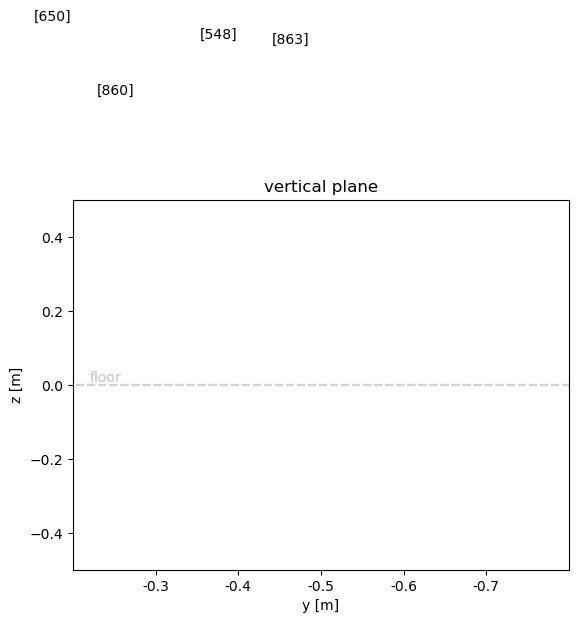

In [30]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    # we mirror the y coordinate, because in the robot coordinate system y < 0 indicates a position to the right of the 
    # robot, but in the pyplot visualisation values < 0 are displayed on the left. The x ticks are adjusted accordingly.
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z [m]")
    plt.xlabel("y [m]")
    plt.xlim([0.2, 0.8])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.22, 0.01, "floor", color="lightgray")
    plt.xticks([0.3,0.4,0.5,0.6,0.7], [-0.3,-0.4,-0.5,-0.6,-0.7])
plt.title("vertical plane")

The measurement error from the previous pose estimation step obviously still exists, but overall our measurement is still good enough to use it, for example for navigation.

Finally, we again visualise the positions of the markers in the horizontal plane. This time we also visualise the position of our robot. This gives us essentially a section of our world map.

Text(0.5, 1.0, 'horizontal plane')

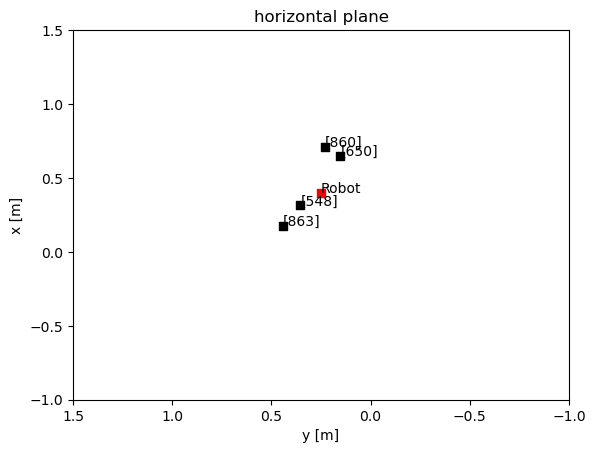

In [31]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)
plt.gca().invert_xaxis()
plt.scatter([y_offset_world], [x_offset_world], color="red", marker="s")
plt.text(y_offset_world, x_offset_world, "Robot")
plt.title("horizontal plane")